# Getting to know your data
One of the most difficult parts of being a data scientist is getting familiarized with your data, as well as explaining to the business the key point that drove you to the solution.

So at first we are going to state the problem:
> "With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home."


# Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm # for some statistics
from scipy.stats import skew  
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

**Scipy**: provides algorithms for optimization, integration, interpolation, eigenvalue problems, algebraic equations, differential equations, statistics and many other classes of problems.

In [ ]:
#bring in the data
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

# Familiarizing with your data

In [ ]:
# Changing the default pandas settings to see the full table
pd.set_option('display.max_rows', 1000); pd.set_option('display.max_columns', 1000); 

In [ ]:
df_train.columns

In [ ]:
df_train.head(5)

Let's describe the numerical variables.

In [ ]:
df_train.describe().T

Let's describe the categorical ones.

In [ ]:
df_train.describe(include='O').T

In [ ]:
df_train.shape

# Bivariate Analysis

### Plotting the SalePrice against different numerical variables as per their sale conditions.

In [ ]:
sns.set_theme()
features=[i for i in (df_train.iloc[:,1:-1]).columns if df_train[i].nunique() > 25 ]

plt.style.use(plt.style.available[19])
i = 1
plt.figure(figsize=(20,25))
for j in features:
    plt.subplot(6, 3, i)
    sns.scatterplot(x=j,data=df_train, y=df_train['SalePrice'], hue='OverallQual',palette='rocket')
    plt.xlabel(j)
    i += 1
plt.show()

### Number of houses sold by every Overall Quality group.

In [ ]:
plt.figure(figsize=(22,6))
sns.countplot(data=df_train, x='OverallQual');

### Understanding the distribution of categorical variables

In [ ]:
sns.set_theme()
fig=plt.figure(figsize=(20,40))
for i in range(len((df_train.select_dtypes(include='object')).columns)):
    fig.add_subplot(11,4,i+1)
    df_train.select_dtypes(include='object').iloc[:,i].value_counts().plot(kind="pie", subplots=True)

# Data Cleansing

## Outlier Analysis

### Based on the Bivariate Analysis of the numerical variables, we can detect outliers and extract them from our training dataset
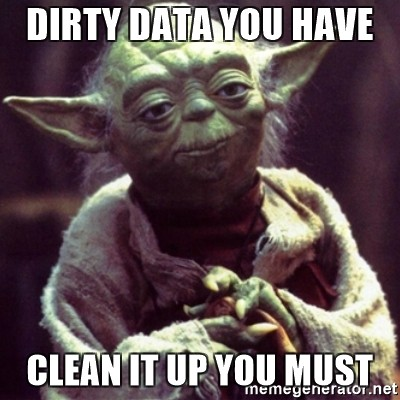

In [ ]:
sns.set_theme()
for i in (df_train[['BsmtFinSF2', 'BsmtFinSF1', 'MasVnrArea', 'LotArea', 'LotFrontage']].columns):
    plt.figure(figsize=(15,6))
    sns.scatterplot(x=i,data=df_train,y=df_train['SalePrice'])
    plt.title('SalePrice against {}'.format(i))
    plt.show()

In [ ]:
df_train= df_train[~((df_train['BsmtFinSF2']>1200) |(df_train['ScreenPorch']>350)|(df_train['GrLivArea']>4000)|(df_train['OpenPorchSF']>350)|(df_train['EnclosedPorch']>350)| (df_train['BsmtFinSF1']>3000) |(df_train['MasVnrArea']>1200) |(df_train['LotArea']>100000) | (df_train['LotFrontage']>200))]

## Cleaning the nulls

### Combining training & testing dataset

In [ ]:
data=pd.concat([df_train, df_test], axis=0)

### Understanding the nulls

In [ ]:
df=pd.DataFrame({'Type': data.dtypes,
                  'Missing': data.isna().sum(),
                  'Size':data.shape[0],
                  'Unique': data.nunique()})
df['Missing_%']= (df.Missing/df.Size)*100
df[df['Missing']>0].sort_values(by=['Missing_%'], ascending=False)

In [ ]:
percent = ((data.isnull().sum()/data.isnull().count()).sort_values(ascending=False) * 100)
missing_data = pd.concat([percent], axis=1, keys=[ 'Percent'])
missing_data = missing_data[missing_data['Percent'] > 0]
f, ax = plt.subplots(figsize=(10, 8))
plt.xticks(rotation='90')
sns.barplot(data=missing_data, x=missing_data.index, y="Percent")
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15);

SalePrice: The idea behind this competition is predict saleprice values for the test dataset. These missing values hence represent empty cells. While addressing the missing values issue using median value, it is important to ignore this column.

Let's make sure that SalePrice remains unaffected.

### Data Imputation

#### Categorical Variables
**PoolQC**: Missing value indicates No pool as few dwellings are likely to have pool.

**MiscFeature**: Data Description text file indicates NA means None.

**Alley**: Data Description text file indicates NA means 'No alley access' regarding Alley column. It is likely that missing values are NA.

**Fence**: Similar reasoning as previous code cell.

**FireplaceQC**:It is likely that certain share of dwellings will not have any fireplace.

**GarageType**:Similar reasoning as previous code cell.

**GarageFinish**: If the GarageType is 'NA', then 'GarageFinish' missing values should be denoted as 'NA'.

**GarageQual**: Similarly, All the missing values in GarageQual column have 'NA' as a garage type.

**GarageCond**: Similar reasoning for GarageCond column as mentioned in the previous cell.

**Basement Condition**:Unique values with missing values do not indicate a single dwelling that has no basement. Similar assumption as Garagetype is taken into considertaion. Certain share of dwellings likely to have no basement.

**BasementExposure**: All the 37 missing values in BsmtExposure column have NO basement as the basement type.

**BasementQuality and BasementFintype1**: Similar reasoning as the above.

**BasementFinType2**: All the missing values are assumed 'NA'.

**Masonry veneer type**: Observations with missing values in the MasVnrType column have missing values in MasVnrArea as well, let's replace them with 'None'.

**Electrical**: The missing observation is replaced by the most frequent category.

**MSSubClass**: Let's make MSSubclass a categorical variable as numbers represent the belonging class.

**MoSold**: is assumed categorical variable as well.

**Regarding MsZoning, Functional, Utilities, KitchenQual, Exterior2nd,Exterior1st and Saletype**: missing values are replaced with most frequent observation for the respective columns.

In [ ]:
def categorical_imputation(df):
    df['PoolQC']=df['PoolQC'].fillna('NA')
    df['MiscFeature']=df['MiscFeature'].fillna('NA')
    df['Alley']=df['Alley'].fillna('NA')
    df['Fence']=df['Fence'].fillna('NA')
    df['FireplaceQu']=df['FireplaceQu'].fillna('NA')
    df['GarageType']=df['GarageType'].fillna('NA')
    df['BsmtCond']=df['BsmtCond'].fillna('NA')
    df['BsmtExposure']=df['BsmtExposure'].fillna('NA')
    df['BsmtQual']=df['BsmtQual'].fillna('NA')
    df['BsmtFinType2']=df['BsmtFinType2'].fillna('NA')
    df['Electrical']=df['Electrical'].fillna(df['Electrical'].mode()[0])
    df['GarageCond']=df['GarageCond'].fillna('NA')
    df['GarageQual']=df['GarageQual'].fillna('NA')
    df['GarageFinish']=df['GarageFinish'].fillna('NA')
    df['BsmtFinType1']=df['BsmtFinType1'].fillna('NA')
    df['MasVnrType']=df['MasVnrType'].fillna('None')
    df['MSZoning']=df['MSZoning'].fillna('RL')
    df['Functional']=df['Functional'].fillna('Typ')
    df['Utilities']=df['Utilities'].fillna('AllPub')
    df['KitchenQual']=df['KitchenQual'].fillna('TA')
    df['Exterior2nd']=df['Exterior2nd'].fillna('VinylSd')
    df['Exterior1st']=df['Exterior1st'].fillna('VinylSd')
    df['SaleType']=df['SaleType'].fillna('WD')
    df['MSSubClass']=df['MSSubClass'].astype(object)
    df['MoSold']=df['MoSold'].astype(object)
    df_null=pd.DataFrame({'Type': df.dtypes,
                  'Missing': df.isna().sum(),
                  'Size':df.shape[0],
                  'Unique': df.nunique()})
    df_null['Missing_%']= (df_null.Missing/df_null.Size)*100
    display(df_null[df_null['Missing']>0].sort_values(by=['Missing_%'], ascending=False))
    return df;

In [ ]:
# Running the python function
df_train_transformed = categorical_imputation(df_train)
df_test_transformed = categorical_imputation(df_test)

#### Numeric Variables

Let's replace all numeric variables with their median.

In [ ]:
def numerical_imputation(df):
    df_null=pd.DataFrame({'Type': df.dtypes,
                  'Missing': df.isna().sum(),
                  'Size':df.shape[0],
                  'Unique': df.nunique()})
    for i in df_null[df_null['Missing']>0].index:
        if i=='SalePrice':
            continue
        else:
            df[i]=df[i].fillna(df[i].median())
    df_null=pd.DataFrame({'Type': df.dtypes,
                  'Missing': df.isna().sum(),
                  'Size':df.shape[0],
                  'Unique': df.nunique()})
    df_null['Missing_%']= (df_null.Missing/df_null.Size)*100
    display(df_null[df_null['Missing']>0].sort_values(by=['Missing_%'], ascending=False))
    return df;

In [ ]:
# Running the python function
df_train_transformed = numerical_imputation(df_train_transformed)
df_test_transformed = numerical_imputation(df_test_transformed)                                            

In [ ]:
# Merging into one dataframe
data=pd.concat([df_train_transformed, df_test_transformed], axis=0)

# Feature Engineering

## Target Variable Normalization

* **What is a Normal Distribution?**

A Normal distribution is simple, it's where mean, median and mode have the same value.

Unfortunately, our real-life datasets do not always follow the normal distribution.

In [ ]:
# Good News: Seems that your minimum price is larger than zero
df_train['SalePrice'].describe()

In [ ]:
# Let's see the histogram
sns.histplot(df_train['SalePrice'], kde=True);

Let's see the QQ Plot.
QQ Plot Definition: A quantile-quantile (Q-Q) plot, shows the distribution of the data against the expected normal distribution. For normally distributed data, observations should lie approximately on a straight line

In [ ]:
#It doesn't look like a normal distribution
stats.probplot(df_train['SalePrice'], plot=sns.mpl.pyplot);

Let's see the skewness and kurtosis.
* **Skewness**: Skewness is a measure of the asymmetry of a distribution. A distribution is asymmetrical when its left and right side are not mirror images. A distribution can have right (or positive), left (or negative), or zero skewness.

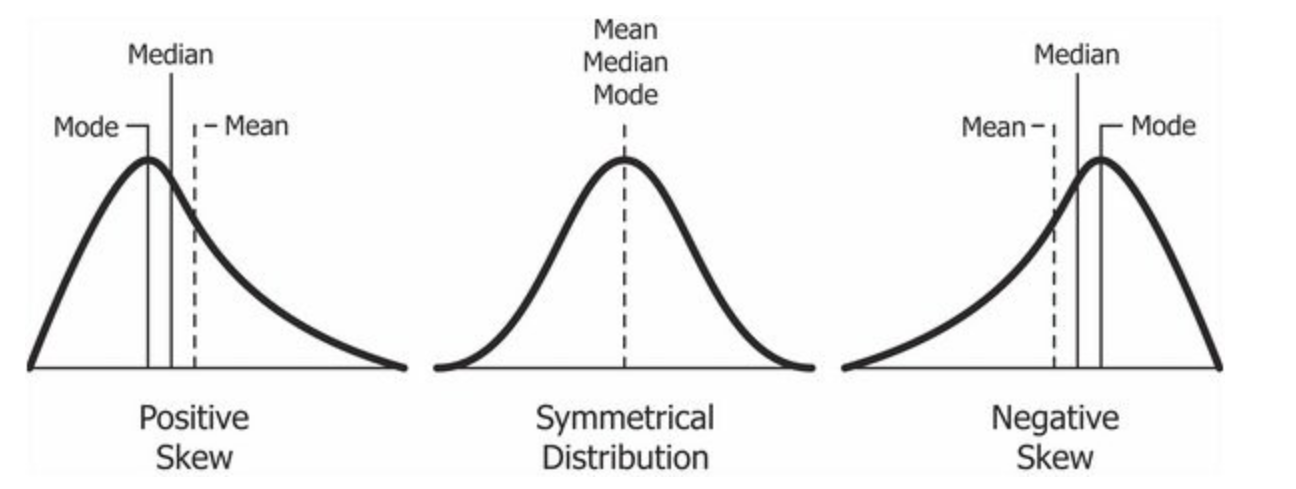

* **Kurtosis**: Kurtosis is a statistical measure that defines how heavily the tails of a distribution differ from the tails of a normal distribution. 

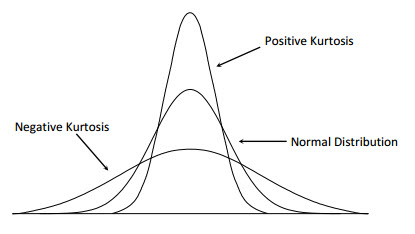

In [ ]:
# So we do have to normalize our data
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Let's normalize our target variable with Log.

* **What is Logarithm?**

A logarithm can be defined with respect to a base (b) where the base b-logarithm of X is equal to y because X equals to the b to the power of y (log(X) =y because X = b ʸ).
* Base 2 — the base 2 logarithm of 8 is 3, because 2³ = 8
* Base 10 — the base 10 logarithm of 100 is 2, because 10² = 100
* Natural Log — the base of the natural log is the mathematical constant “e” or Euler’s number which is equal to 2.718282. So, the natural log of 7.389 is 2, because e² = 7.389.

* **What is Log Transformation?**

Log transformation is a data transformation method in which it replaces each variable x with a log(x). 

When our original continuous data do not follow the bell curve, we can log transform this data to make it as “normal” as possible so that the statistical analysis results from this data become more valid. 

> The important caveat here is that the original data has to follow or approximately follow a log-normal distribution. Otherwise, the log transformation won’t work.


Reference: https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9

In [ ]:
df_train.reset_index(drop=True, inplace=True)
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])
# Let's see the histogram
sns.histplot(df_train['SalePrice'], kde=True);


In [ ]:
# Let's see the QQ Plot histogram
stats.probplot(df_train['SalePrice'], plot=sns.mpl.pyplot);

In [ ]:
#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())


Now our target variable is normalized and we can keep going.

## Data Correlation

Eventhough we are not going to reduce the number of features that we are going to use to build our ML models, it is important to know the correlation between them.

* **What is correlation?**
    
    Correlation is a statistical term describing the degree to which two variables move in coordination with one another. If the two variables move in the same direction, then those variables are said to have a positive correlation. If they move in opposite directions, then they have a negative correlation.

Reference: https://www.investopedia.com/terms/c/correlation.asp#:~:text=Correlation%20is%20a%20statistical%20term,they%20have%20a%20negative%20correlation.

In [ ]:
#correlation matrix
corrmat = df_train_transformed.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [ ]:
#saleprice correlation matrix
k = 11 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
print(cols)
cm = np.corrcoef(df_train_transformed[cols].values.T)
sns.set(font_scale=1.25);
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values);
plt.show();

## Variable Categorization

This competition provides a text file which explains the variables. All the variables are categorized manually using the information provided in the text file.
* **Categorical Variable**: Variable that has two or more categories, but there is no intrinsic ordering to the categories.
* **Ordinal Variable**: Similar of categorical but there is a clear ordering of the categories.
* **Numerical variables**: Variable that can be measured and that can assume different values. 

In [ ]:
categorical=['MSSubClass', 'MSZoning', 'LotConfig', 'Neighborhood', 'LandSlope', 'LandContour',
             'Condition1','Condition2','BldgType', 'HouseStyle', 'YearBuilt',
             'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd','RoofMatl',
            'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'Fence',
            'MiscFeature', 'MoSold' ,'YrSold', 'SaleType', 'PavedDrive','Alley','SaleCondition' ]

In [ ]:
ordinal=['LotShape', 'ExterQual','ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
         'BsmtFinType1', 'BsmtFinType2','HeatingQC','KitchenQual', 'Functional', 
        'FireplaceQu', 'GarageFinish','GarageQual', 'GarageCond', ]

In [ ]:
numerical=['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
          'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 
          '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath','FullBath',
          'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
           'GarageCars', 'GarageArea', 'WoodDeckSF','OpenPorchSF', 'EnclosedPorch',
          'ScreenPorch', 'MiscVal', 'GarageYrBlt' ]

Let's transform the ordinal ones.

In [ ]:
ex_qu= { 'Po':0, 'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3 }
ex_cond={ 'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4 }
Bsmt_Qual={"NA": 0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5 }
BsmtFinType1={ "NA": 0, 'Unf':0, 'LwQ': 1, 'Rec': 2, 'BLQ': 3, 'ALQ': 4, 'GLQ':5 }
Bsmt_Exposure={ "NA":0, "No": 0, "Mn": 1, "Av": 2, "Gd": 3}
garage_fin={'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
garage_qu= { "NA": 0, 'Po':0, 'Fa':1, 'TA': 2, 'Gd': 3, 'Ex': 4  }
LotShape={"IR3": 0, 'IR2':0, 'IR1': 1, 'Reg': 2}
Functional={"Sal": 0, 'Sev':1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2':5, 'Min1':6, 'Typ':7}

data=data.replace({"LotShape": LotShape,
                    "ExterQual": ex_qu,
                   "ExterCond": ex_cond,
                   "BsmtQual": Bsmt_Qual,
                   "BsmtCond": Bsmt_Qual,
                   "BsmtExposure": Bsmt_Exposure, 
                   "BsmtFinType1": BsmtFinType1, 
                   "BsmtFinType2": BsmtFinType1,
                   "HeatingQC": ex_qu,
                   "KitchenQual": ex_qu,
                   "Functional": Functional,
                    "GarageFinish": garage_fin,
                    "GarageQual": garage_qu,
                    "GarageCond": garage_qu,
                    "FireplaceQu": garage_qu})

In [ ]:
X1=data[ordinal]
X2=pd.get_dummies(data[categorical], drop_first=True)
X3=data[numerical]

### Fixing the skewed variables.
In order to avoid data leakage from the observations in the test csv file into train csv file, I will convert X3 into X3_train and X3_test file and then apply box-cox transformation.

* **What is the box-cox transformation?**

A Box Cox transformation is a transformation of non-normal dependent variables into a normal shape. Normality is an important assumption for many statistical techniques; if your data isn’t normal, applying a Box-Cox means that you are able to run a broader number of tests.

Source: https://www.statisticshowto.com/probability-and-statistics/normal-distributions/box-cox-transformation/ 



In [ ]:
X3_train=X3.iloc[:len(df_train),:]
X3_test=X3.iloc[len(df_train):,:]

* Let's start with the training dataset

In [ ]:
skewed_columns=[]
for i in X3_train.columns:
    if abs(X3_train[i].skew())> 0.5:
        skewed_columns.append(i)
print(skewed_columns)
lam=0.15
for i in skewed_columns:
    X3_train[i]= boxcox1p(X3_train[i],lam)

Let's do it with the testing dataset

In [ ]:
lam=0.15
for i in skewed_columns:
    X3_test[i]= boxcox1p(X3_test[i],lam)

Let's merge these two X3_train and X3_test files to revert back to the same dimension as X2 and X1.

In [ ]:
X3=pd.concat([X3_train,X3_test], axis=0)


In [ ]:
dataset=(pd.concat([X2, X1, X3], axis=1))

Separating the transformed dataset into training and testing

In [ ]:
test_dataset=dataset.iloc[len(df_train):,:]
test_dataset

In [ ]:
train_dataset=dataset.iloc[:len(df_train),:]
train_dataset

Getting ready for the ML modelling.

In [ ]:
X=dataset.iloc[:len(df_train),:].values
X_test=dataset.iloc[len(df_train):,:].values
y = df_train['SalePrice'].reset_index(drop=True)

## ML Modelling

## Importing the ML Libraries

**Sklearn**: Scikit-learn is a library in Python that provides many unsupervised and supervised learning algorithms.

In [ ]:
from datetime import datetime
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import os
print(os.listdir("../input"))

##  Building the ML Models

Starting the modelling process.

* **K-Folds cross-validation**
    
    Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.
    
    The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation.
    
    Source: https://machinelearningmastery.com/k-fold-cross-validation/

* Error evaluation metrics
 * **RMSE:**
    
        Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are.
    
        The formula is:
        
 ![im](https://images.squarespace-cdn.com/content/v1/58c95854c534a56689231265/1531152039771-PI1ZAS4DSZCCUBST3KEK/Formula.PNG) 
 
        Where:
        - f = forecasts (expected values or unknown results),
        - o = observed values (known results).
        
        
 * **RMSLE:**

![im2](https://hrngok.github.io/images/cost.jpg) 

        It is the Root Mean Squared Error of the log-transformed predicted and log-transformed actual values.
        
        RMSLE adds 1 to both actual and predicted values before taking the natural logarithm to avoid taking the natural log of possible 0 (zero) values.

        As a result, the function can be used if actual or predicted have zero-valued elements. But this function is not appropriate if either is negative valued

        RMSLE is preferable when
        
        > targets having exponential growth, such as population counts, average sales of a commodity over a span of years etc
        > we care about percentage errors rather than the absolute value of errors.
        > there is a wide range in the target variables and
        > we don’t want to penalize big differences when both the predicted and the actual are big numbers.
        > we want to penalize under estimates more than over estimates.
    

In [ ]:
X.shape, y.shape

In [ ]:
# Creating the python functions for error metrics evaluation

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [ ]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

**Explaining the models that we are going to evaluate.**

* **Ridge**

    Ridge Regression is a technique for analyzing multiple regression data that suffer from multicollinearity. When multicollinearity occurs, least squares estimates are unbiased, but their variances are large so they may be far from the true value. By adding a degree of bias to the regression estimates, ridge regression reduces the standard errors. 

    Multicollinearity is a statistical concept where several independent variables in a model are correlated. Two variables are considered to be perfectly collinear if their correlation coefficient is +/- 1.0. Multicollinearity among independent variables will result in less reliable statistical inferences.

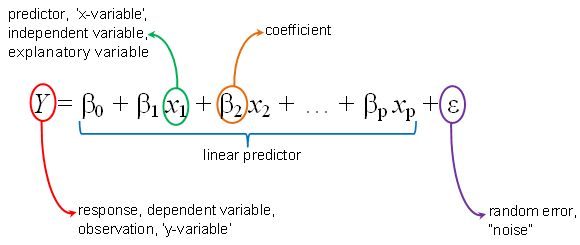

Source: https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Ridge_Regression.pdf

* **Lasso**
    
    Lasso regression is a type of linear regression that uses shrinkage. Shrinkage is where data values are shrunk towards a central point, like the mean. The lasso procedure encourages simple, sparse models (i.e. models with fewer parameters). This particular type of regression is well-suited for models showing high levels of muticollinearity or when you want to automate certain parts of model selection, like variable selection/parameter elimination.

Source: https://www.statisticshowto.com/lasso-regression/

* **Elastict Net**

    In statistics and, in particular, in the fitting of linear or logistic regression models, the elastic net is a regularized regression method that linearly combines the L1 and L2 penalties of the lasso and ridge methods.
    
Source: https://en.wikipedia.org/wiki/Elastic_net_regularization

* **SVR**

    Unlike in the Ordinary Least Squares, the SVR model sets a threshold error allowance ϵ around the regression line such that all the data points within ϵ are not penalized for their error.

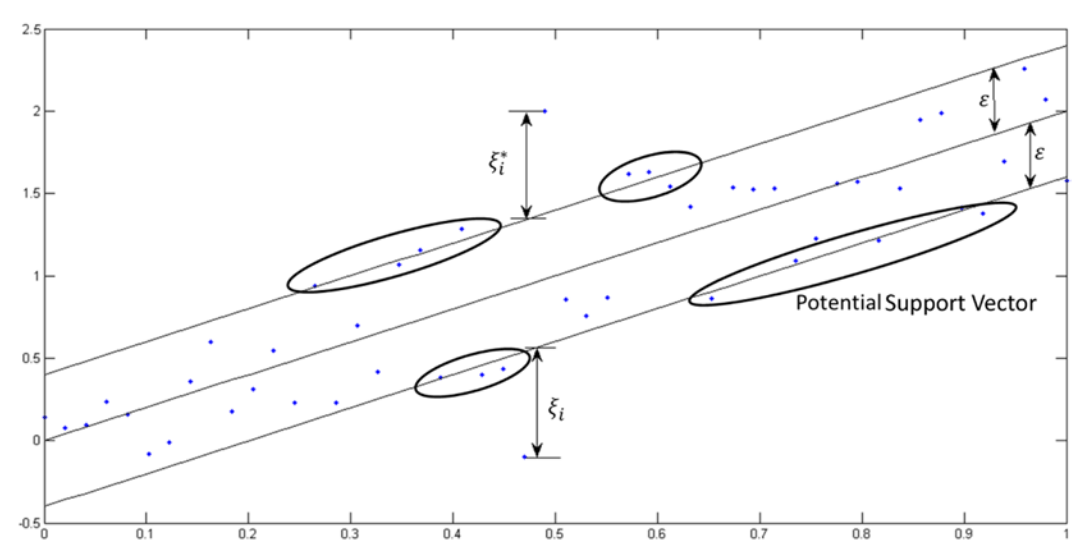
 
Source: https://www.section.io/engineering-education/support-vector-regression-in-python/


* **GBM**

    Gradient Boosting is a system of machine learning boosting, representing a decision tree for large and complex data. It relies on the presumption that the next possible model will minimize the gross prediction error if combined with the previous set of models. The decision trees are used for the best possible predictions. 

Source: https://www.wallstreetmojo.com/gradient-boosting/

* **XGboost**

    XGBoost is a scalable and highly accurate implementation of gradient boosting that pushes the limits of computing power for boosted tree algorithms, being built largely for energizing machine learning model performance and computational speed. With XGBoost, trees are built in parallel, instead of sequentially like GBDT. It follows a level-wise strategy, scanning across gradient values and using these partial sums to evaluate the quality of splits at every possible split in the training set. 

Source: https://www.nvidia.com/en-us/glossary/data-science/xgboost/

* **Light GBM**

    LightGBM has many of XGBoost's advantages, including sparse optimization, parallel training, multiple loss functions, regularization, bagging, and early stopping. A major difference between the two lies in the construction of trees. LightGBM does not grow a tree level-wise — row by row — as most other implementations do.Instead it grows trees leaf-wise. It chooses the leaf it believes will yield the largest decrease in loss.

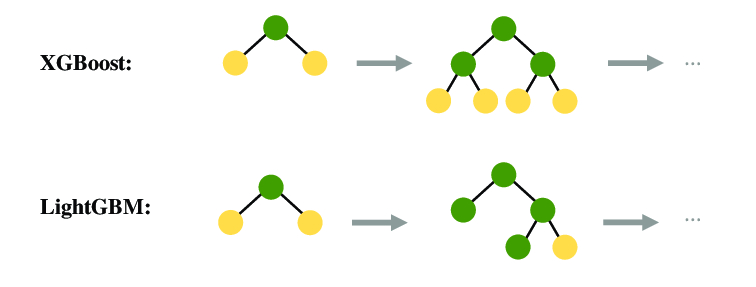

Source: https://en.wikipedia.org/wiki/LightGBM


In [ ]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))


In [ ]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)   

In [ ]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [ ]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [ ]:
# Using various prediction models that we just created 

score = cv_rmse(ridge , X)
print("RIDGE: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso , X)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )


score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

## Ensembling Meta Model

In [ ]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

print('Ridge')
ridge_model_full_data = ridge.fit(X, y)

print('Svr')
svr_model_full_data = svr.fit(X, y)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

## Blending the prediction

In [ ]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

In [ ]:
print('RMSLE Ensemble Model score on train data:')
print(rmsle(y, stack_gen_model.predict(np.array(X))))

print('RMSLE Blended Models score on train data:')
print(rmsle(y, blend_models_predict(X)))

> Importat to say that we a see a considerable improvement between our ML models and the Ensemble Model.

## Getting the predictions
Getting the results from the testing dataset in order to score them in the competition.

In [ ]:
print('Predict submission')
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.iloc[:,1] = (np.expm1(blend_models_predict(X_test)))

In [ ]:
q1 = submission['SalePrice'].quantile(0.0042)
q2 = submission['SalePrice'].quantile(0.99)
# Quantiles helping us get some extreme values for extremely low or high values 
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission.csv", index=False)

In [ ]:
submission.head()

# Next steps to improve the results
* Applying IQR as a Method of Outlier Detection.
* Feature Reduction.
* Feature Selection.
* Cross Validation for GBM, LightGBM and XGboost GB.
* Hyperparameter Tuning.

## If you liked this code, please follow me on Kaggle and GitHub (you can find the code there as well).

😺 GitHub Repository Link: https://github.com/Robertosoftware/Advanced-Regression-Housing-Problem

😺 GitHub Profile:  https://github.com/Robertosoftware

ⓚ Kaggle Profile:  https://www.kaggle.com/robertobonilla